In [1]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]

data = data.iloc[:3524]
data_copy = data.copy()

print('Data imported and copied.', flush=True)

Data imported and copied.


In [2]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

period = 60
trend_period = 14
rsi_period = 14
num_features = 1
input_period = 60
output_step = 7
units = 512

In [24]:
data.shape

(3524, 6)

In [3]:
X, y = create_dataset(data[['close']].to_numpy(), time_step=period, output_step=output_step)

In [4]:
X[-5:]

array([[5991.08007812, 5973.60986328, 5934.91015625, 5932.31982422,
        5867.35009766, 5881.33984375, 5937.79003906, 5933.06982422,
        5979.29980469, 5981.91992188, 5995.06005859, 5998.83984375,
        6057.14013672, 6064.56982422, 6058.52978516, 6063.52001953,
        6081.25      , 6069.99023438, 6092.45019531, 6114.52978516,
        6122.60986328, 6114.35009766, 6092.62011719, 6108.81982422,
        6067.83007812, 6080.22021484, 6055.04003906, 6037.87011719,
        6213.47021484, 6227.58984375, 6248.56005859, 6248.64990234,
        6236.39013672, 6295.58007812, 6313.60986328, 6320.77978516,
        6345.81005859, 6312.20996094, 6309.06982422, 6316.18017578,
        6293.64013672, 6258.35986328, 6339.14013672, 6314.50976562,
        6308.60986328, 6378.62988281, 6386.12011719, 6409.29003906,
        6405.97021484, 6422.56005859, 6311.37988281, 6365.56005859,
        6337.87011719, 6263.70019531, 6265.10986328, 6293.04980469,
        6316.27978516, 6344.56982422, 6393.89013

In [5]:
data_input = np.array([np.concatenate((X[i], y[i]), axis=0) for i in range(X.shape[0])])

In [6]:
data_input.shape

(3457, 67)

In [7]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 11  # Window length (must be odd)
polyorder = 2      # Polynomial order

savgol = np.array([ savgol_filter(data_input[i], window_length, polyorder) for i in range(data_input.shape[0]) ])

In [8]:
savgol_cropped = list()

# NO NEED TO CROP
for _savgol in savgol:
    savgol_cropped.append(_savgol)

savgol_cropped = np.array(savgol_cropped)

from sklearn.preprocessing import MinMaxScaler

scaler_savgol = list(MinMaxScaler() for i in range(savgol_cropped.shape[0]))
savgol_scaled = list()

for i in range(savgol_cropped.shape[0]):
    savgol_scaled.append(scaler_savgol[i].fit_transform(savgol_cropped[i].reshape(-1,1)))

savgol_scaled = np.array(savgol_scaled)

X_input = list()
y_input = list()

for savgol in savgol_scaled:
    X_input.append(savgol[:-y.shape[1]])
    y_input.append(savgol[-y.shape[1]:])

X_input = np.array(X_input)
y_input = np.array(y_input)

In [9]:
X_input.shape

(3457, 60, 1)

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Conv1D, AveragePooling1D, Flatten, Reshape, SimpleRNN, GRU, MaxPooling1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Zeros

inputs = Input(shape=(input_period, num_features))

model_cnn = Sequential([
    Conv1D(filters=512, kernel_size=1, activation='relu'),
    Conv1D(filters=512, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dense(units=128),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bilstm = Sequential([
    Bidirectional(LSTM(units=512, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')),
    Dropout(0.2),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bigru = Sequential([
    Bidirectional(GRU(units=512, activation='tanh', return_sequences=True)),
    Dropout(0.4),
    Flatten()
])

model_multilayer_lstm = Sequential([
    LSTM(units=512, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Dropout(0.2),
    LSTM(units=512, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Flatten()
])

output_cnn = model_cnn(inputs)
output_bilstm = model_bilstm(inputs)
output_bigru = model_bigru(inputs)
output_multilayer_lstm = model_multilayer_lstm(inputs)

concatenated_outputs = concatenate([output_cnn, output_bilstm, output_bigru, output_multilayer_lstm])

main_model = Sequential([
    Input(shape=(concatenated_outputs.shape[1],)),
    #Dense(units=output_step),
    Dense(units=output_step, kernel_initializer=Zeros(), use_bias=False),
    Reshape((output_step,1))
])

final_output = main_model(concatenated_outputs)

functional_pipeline = Model(inputs=inputs, outputs=final_output)

2024-06-13 07:26:00.604015: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 07:26:00.937360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 07:26:00.937419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 07:26:00.944741: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 07:26:01.041717: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 07:26:03.086225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [11]:
X_input.shape

(3457, 60, 1)

In [12]:
# Compile the pipeline model
functional_pipeline.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='model_weights_7-online-learning/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the pipeline model
history = functional_pipeline.fit(X_input[-5:], y_input[-5:], epochs=150, batch_size=64, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/150
1/1 [==============================] - 19s 19s/step - loss: 0.9402 - accuracy: 0.0000e+00 - val_loss: 1.6708 - val_accuracy: 0.1429
Epoch 2/150
1/1 [==============================] - 3s 3s/step - loss: 1.0704 - accuracy: 0.1429 - val_loss: 0.1311 - val_accuracy: 0.1429
Epoch 3/150
1/1 [==============================] - 3s 3s/step - loss: 0.0408 - accuracy: 0.1429 - val_loss: 0.0747 - val_accuracy: 0.1429
Epoch 4/150
1/1 [==============================] - 3s 3s/step - loss: 0.1380 - accuracy: 0.1429 - val_loss: 0.1004 - val_accuracy: 0.1429
Epoch 5/150
1/1 [==============================] - 3s 3s/step - loss: 0.1674 - accuracy: 0.1429 - val_loss: 0.0138 - val_accuracy: 0.1429
Epoch 6/150
1/1 [==============================] - 3s 3s/step - loss: 0.0495 - accuracy: 0.1429 - val_loss: 0.0347 - val_accuracy: 0.1429
Epoch 7/150
1/1 [==============================] - 3s 3s/step - loss: 0.0041 - accuracy: 0.1429 - val_loss: 0.1599 - val_accuracy: 0.1429
Epoch 8/150
1/1 [===========

In [18]:
data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup_copy = data_backup.copy()

In [19]:
data_backup.shape

(5033, 6)

In [20]:
X_test, y_test = create_dataset(data_backup[['close']].to_numpy(), time_step=period, output_step=output_step)

In [21]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 17  # Window length (must be odd)
polyorder = 1      # Polynomial order

data_savgol_test = savgol_filter(X_test, window_length, polyorder)

In [22]:
savgol_cropped_test = list()

# NO NEED TO CROP
for _savgol in data_savgol_test:
    savgol_cropped_test.append(_savgol)

savgol_cropped_test = np.array(savgol_cropped_test)

from sklearn.preprocessing import MinMaxScaler

scaler_savgol_test = list(MinMaxScaler() for i in range(savgol_cropped_test.shape[0]))
savgol_scaled_test = list()

for i in range(savgol_cropped_test.shape[0]):
    savgol_scaled_test.append(scaler_savgol_test[i].fit_transform(savgol_cropped_test[i].reshape(-1,1)))

savgol_scaled_test = np.array(savgol_scaled_test)

X_input_test = list()
#y_input = list()

for savgol in savgol_scaled_test:
    X_input_test.append(savgol)
    #y_input.append(savgol[-y.shape[1]:])

X_input_test = np.array(X_input_test)
#y_input = np.array(y_input)

In [28]:
X_input_test.shape[0], 3524-7

(4966, 3517)

In [29]:
savgol_predictions_test = list()

for j in range(3517, 3517+5):
    if (j+1) % 100 == 0:
        print(j+1)
        
    savgol_predictions_test.append(
        scaler_savgol_test[j].inverse_transform(
            functional_pipeline.predict(X_input_test[j].reshape(savgol_scaled_test[j].shape[1], input_period, num_features), verbose=0)[0].reshape(1,output_step)
        )
    )

savgol_predictions_test = np.array(savgol_predictions_test)

In [42]:
savgol_predictions_test[0][0][0]

7001.1953

In [43]:
adjusted_preds = savgol_predictions_test - (savgol_predictions_test[0][0][0] - data_backup['close'].iloc[3517])

In [44]:
adjusted_preds

array([[[6472.48  , 6496.6006, 6507.718 , 6511.179 , 6506.975 ,
         6495.155 , 6475.7563]],

       [[6486.57  , 6511.852 , 6523.3843, 6526.791 , 6522.0684,
         6509.259 , 6488.4097]],

       [[6495.089 , 6520.86  , 6532.5005, 6535.7705, 6530.6636,
         6517.228 , 6495.5107]],

       [[6496.676 , 6522.9204, 6534.674 , 6537.8184, 6532.3457,
         6518.3125, 6495.757 ]],

       [[6478.277 , 6502.586 , 6513.2915, 6515.8823, 6510.3486,
         6496.7554, 6475.1284]]], dtype=float32)

In [33]:
savgol_cropped_test.shape

(4966, 60)

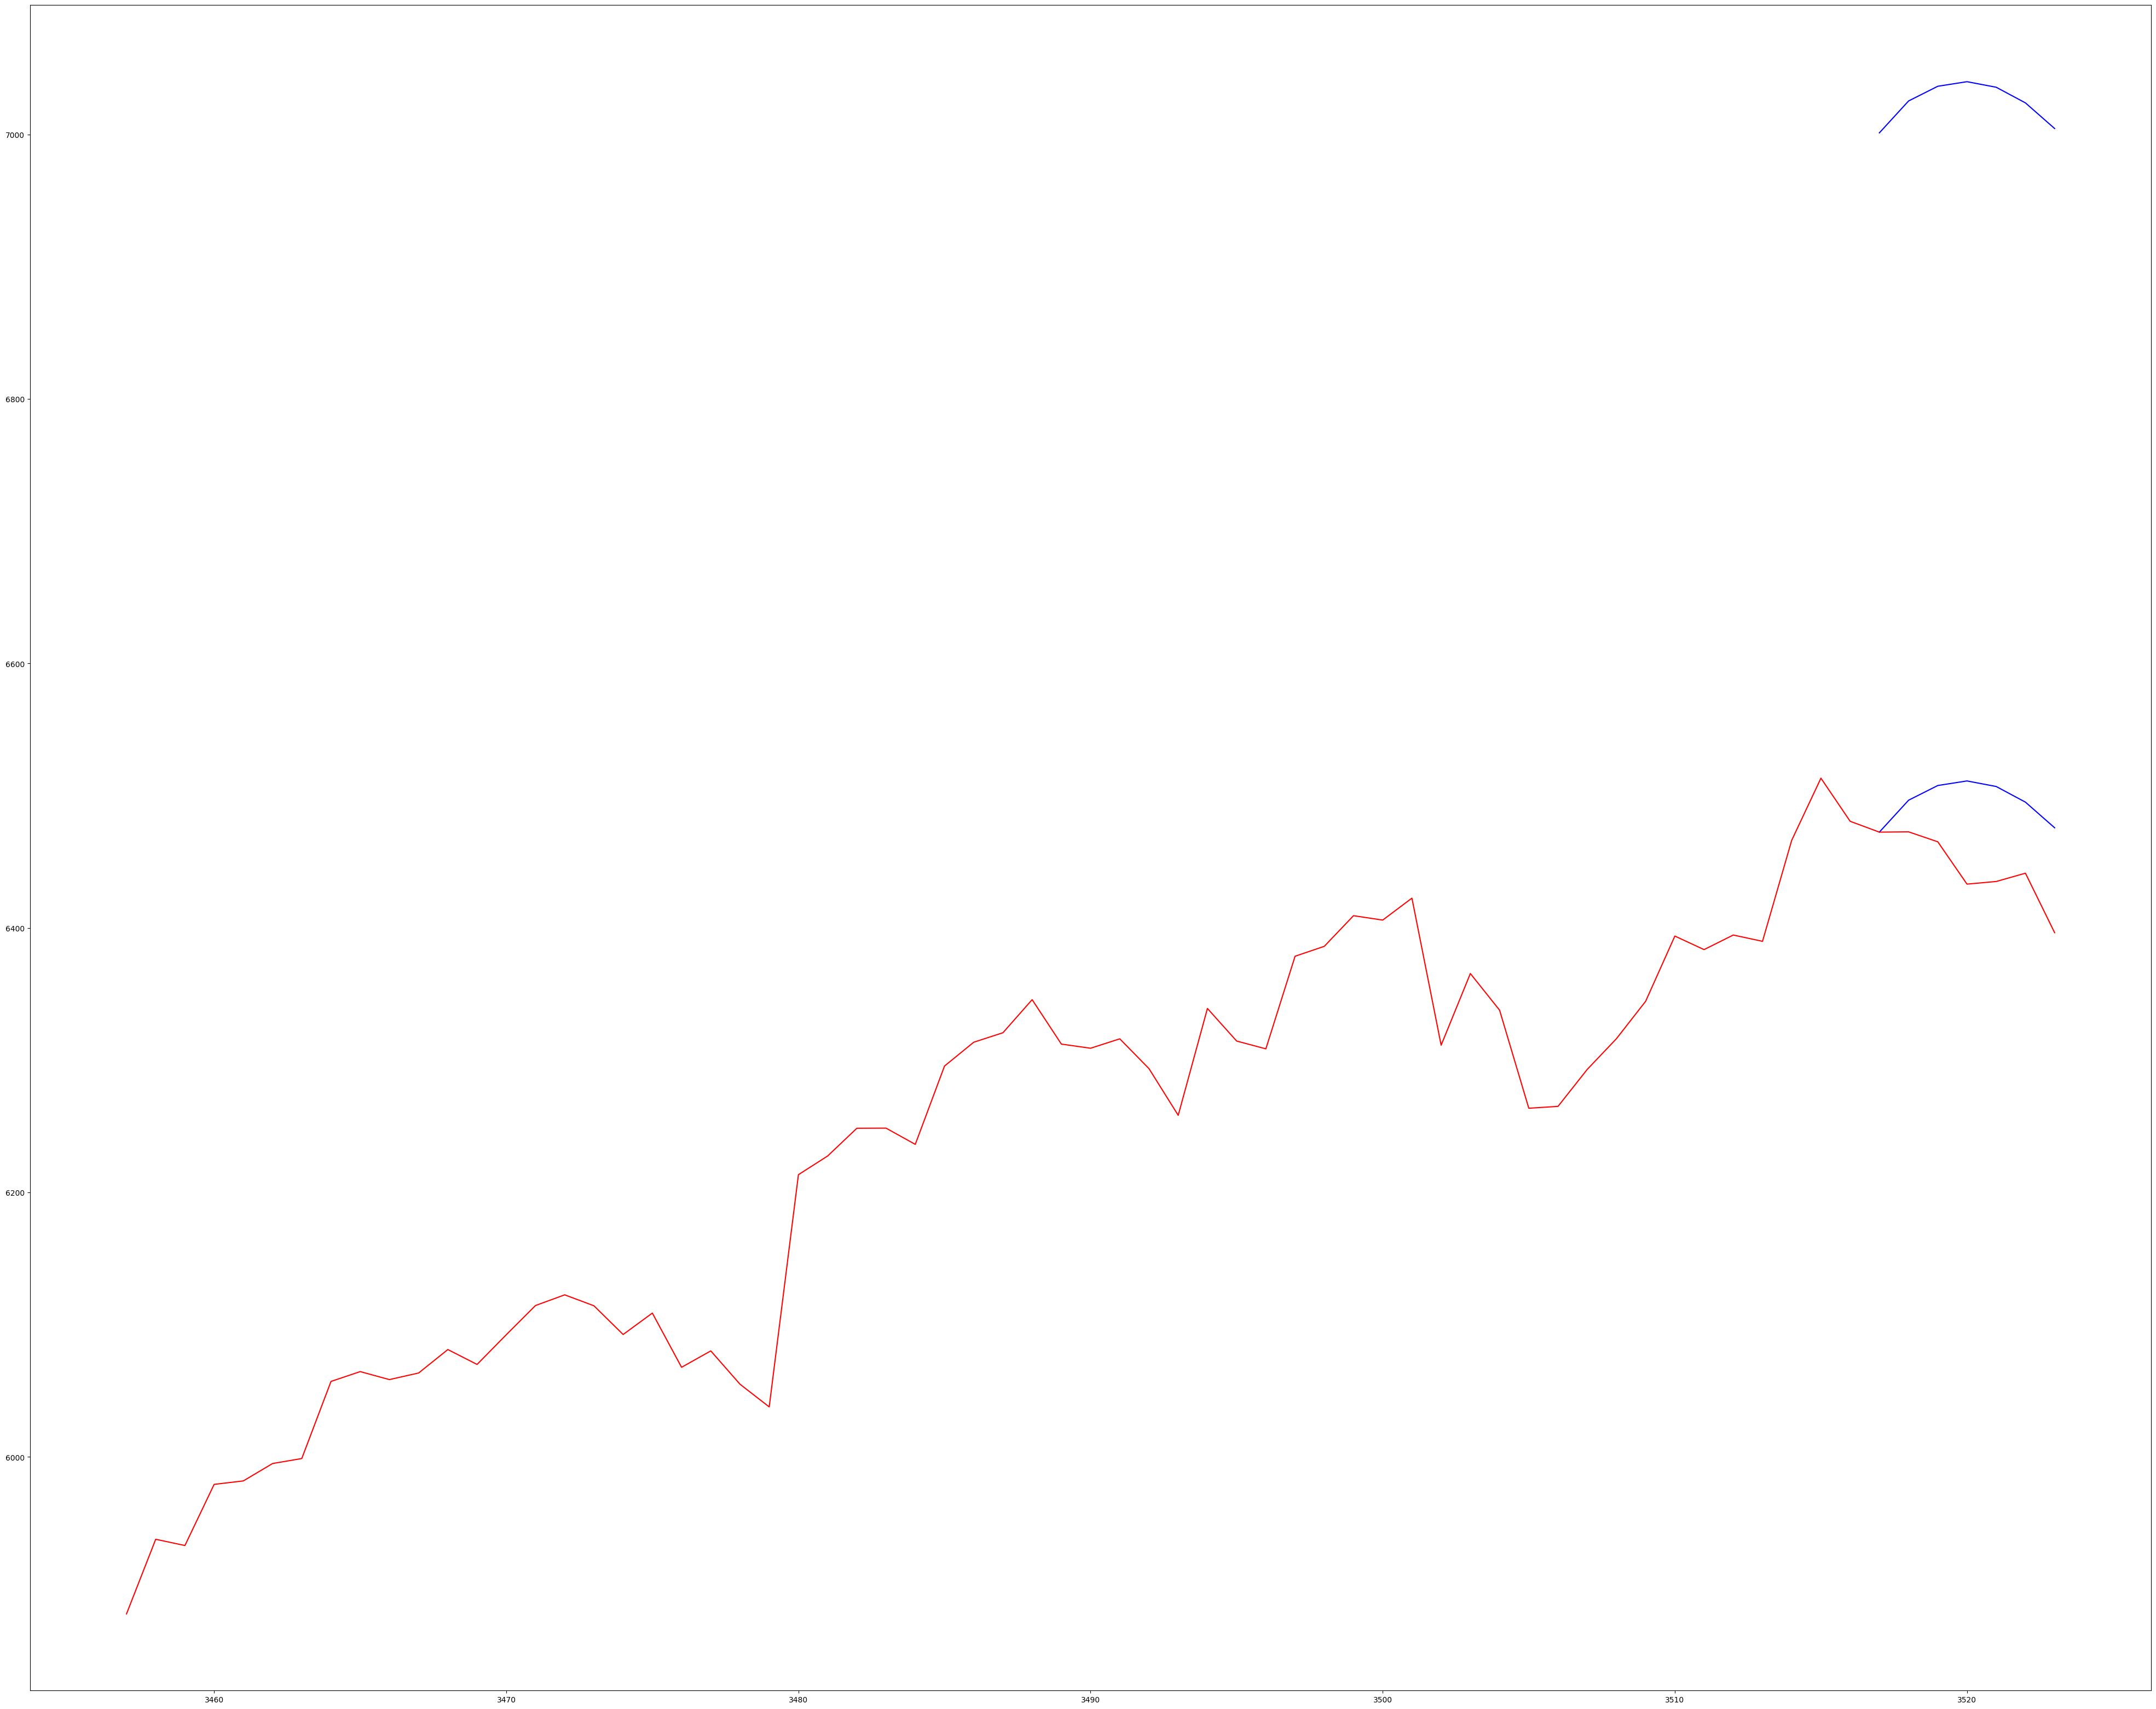

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

t = 0

plt.plot(data_backup.index[t+3517:t+3517+7], savgol_predictions_test[t][0], color='blue')
plt.plot(data_backup.index[t+3517:t+3517+7], adjusted_preds[t][0], color='blue')
#plt.plot(data_backup.index[3517:3517+7], savgol_cropped_test[3517:3517+7], color='black')
plt.plot(data_backup.index[3457:3524], data_backup['close'].iloc[3457:3524], color='red')

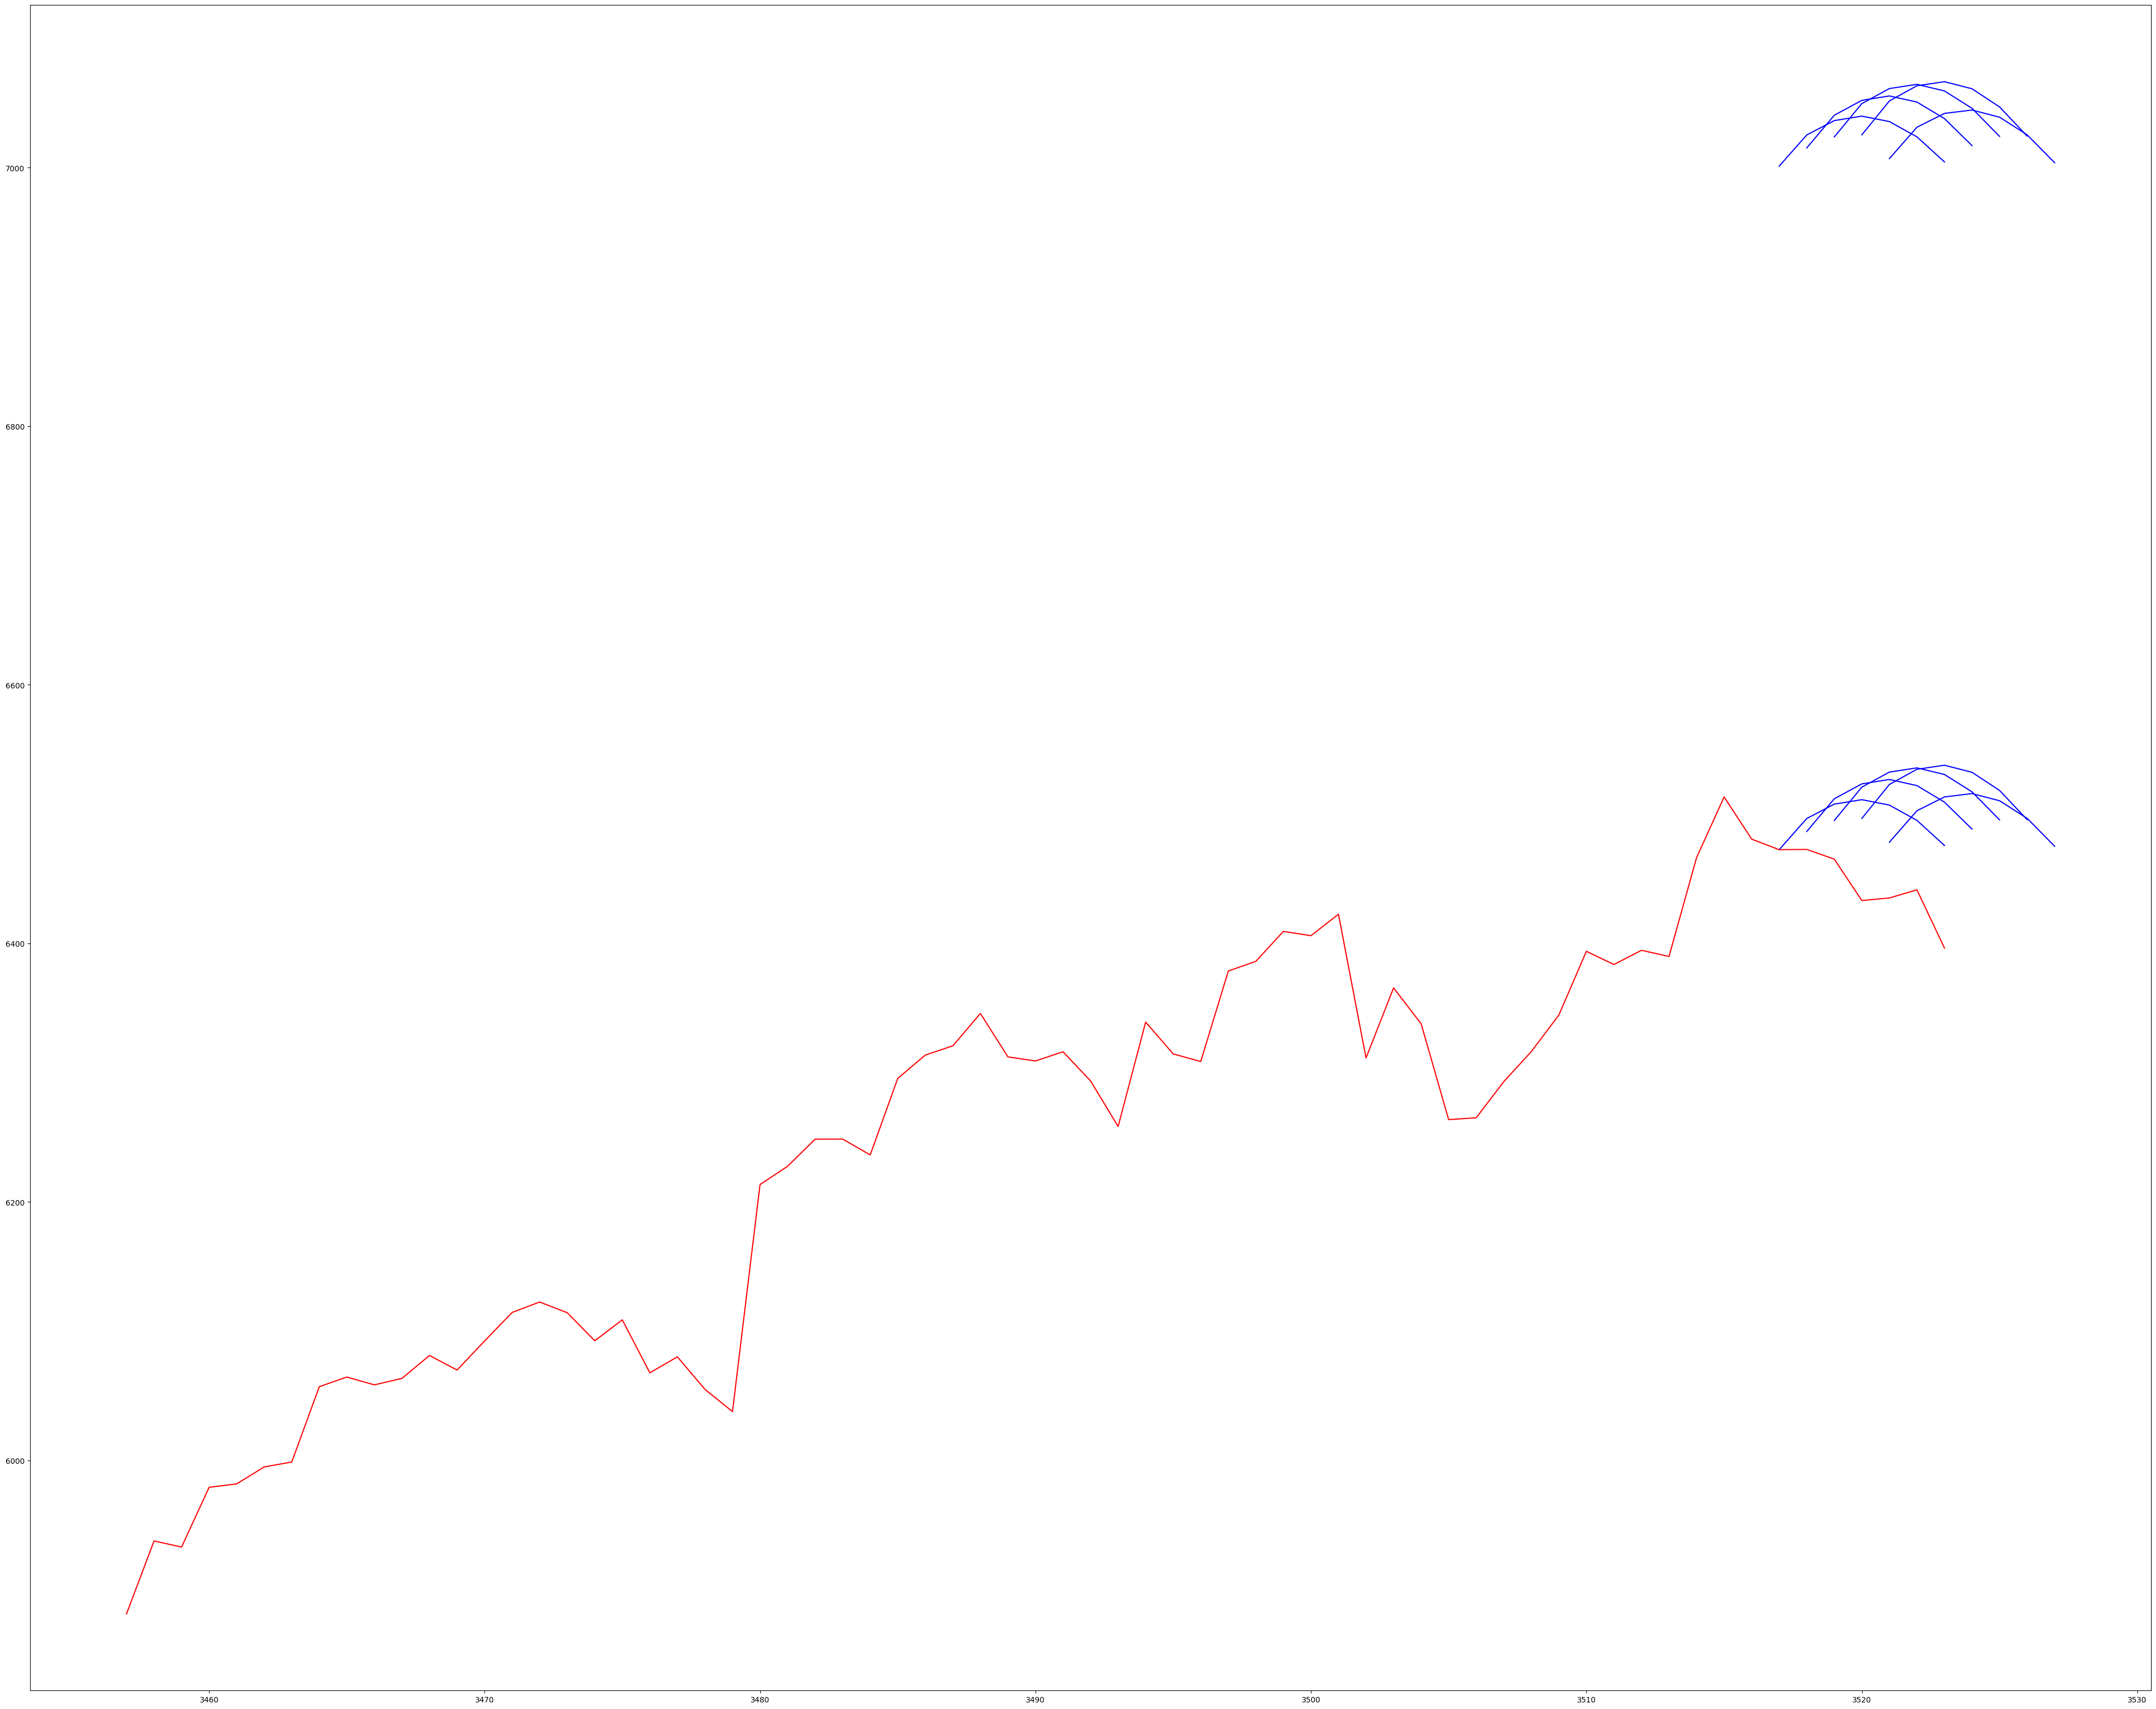

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

for t in range(5):
    plt.plot(data_backup.index[t+3517:t+3517+7], savgol_predictions_test[t][0], color='blue')
    plt.plot(data_backup.index[t+3517:t+3517+7], adjusted_preds[t][0], color='blue')
#plt.plot(data_backup.index[3517:3517+7], savgol_cropped_test[3517:3517+7], color='black')
plt.plot(data_backup.index[3457:3524], data_backup['close'].iloc[3457:3524], color='red')